# **0]  Preliminaries**

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
import urllib
import shutil

import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfpd = tfp.distributions

In [176]:
def opt_dist(dist, dat, lr = 1., iters = 2000):
  """ Optimize dist's params wrt dat"""
  cost = lambda: -tf.reduce_sum(dist.log_prob(dat))
  opt = tf.keras.optimizers.Adam(learning_rate=lr)
  tfp.math.minimize(cost, iters, opt)

def plot_samp_dat(samp, dat, n_bins = 15, xmin = None, xmax = None):
  """ Double histogram of two data."""
  fig=plt.figure()
  all = np.concatenate([samp, dat])
  if xmin is None:
    xmin = np.min(all)
  if xmax is None:
    xmax = np.max(all)
  bins = np.linspace(xmin, xmax, n_bins)
  plt.hist(dat, alpha = 0.7, bins = bins, label = 'data', density = True)
  plt.hist(samp, alpha = 0.5,  bins = bins, label = 'sample', density = True)
  plt.legend()

In [177]:
def make_height_data():
  N = 200
  sex = np.random.choice(2,N)
  mu_male = 69.
  sigma = 0.5
  mu_female = 65
  dat = np.random.normal(loc=np.array([mu_male,mu_female])[sex], scale = sigma)
  return dat

def make_migration_data():
  np.random.seed(123)
  T = 300
  D = 3
  N = T*D
  P = 7
  X = tf.cast(tf.math.pow(tfp.distributions.Uniform().sample(sample_shape=[N,P]), 2), tf.float64)
  #print(X)
  beta = np.array([-2,2]+[0 for _ in range(P-2)]).astype(np.float64)
  log_mu = tf.linalg.matvec(X, beta)+1.
  r = tf.cast(0.3, tf.float64)
  y_nz = tf.cast(tfp.distributions.NegativeBinomial(total_count=r, logits=log_mu).sample(), tf.int64)
  p_zero = 0.8
  y = np.random.binomial(1,p_zero,size=N)*y_nz
  dests = np.array(['Romania', 'Poland', 'Maldova'])
  dests = np.tile(dests,T)
  return X, y, dests

tf.Tensor(
[ 0.18879339  0.30807823 -1.2506987  -1.6113487  -1.588762    1.3293613
 -2.4950235   0.50453603  0.48561084  0.841041  ], shape=(10,), dtype=float32)


(array([ 6., 12., 26., 49., 40., 29., 24., 10.,  1.,  3.]),
 array([-2.4950235 , -1.9319105 , -1.3687974 , -0.80568445, -0.2425714 ,
         0.32054162,  0.88365465,  1.4467677 ,  2.0098808 ,  2.5729938 ,
         3.1361067 ], dtype=float32),
 <a list of 10 Patch objects>)

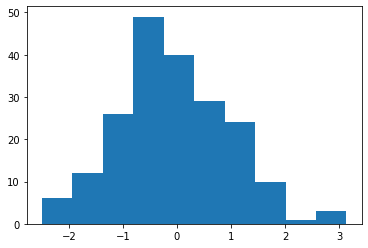

In [178]:
dat = tfpd.Normal(loc=0., scale = 1.).sample(sample_shape=200)
print(dat[:10])
plt.hist(dat)

# **1] Abalone Length**




In [179]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
filename = "abalone.data"
urllib.request.urlretrieve(url, filename)
df = pd.read_csv(filename)
os.remove(filename)

[0.225 0.175 0.185 0.205 0.19  0.13  0.515 0.215 0.18  0.17  0.07  0.1
 0.1   0.16  0.09  0.12  0.115 0.115 0.12  0.13  1.13  0.12  0.11  0.11
 0.09  0.14  0.135 0.135 0.11  0.135]


(array([19.,  7.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.]),
 array([0.07      , 0.14066667, 0.21133333, 0.282     , 0.35266667,
        0.42333333, 0.494     , 0.56466667, 0.63533333, 0.706     ,
        0.77666667, 0.84733333, 0.918     , 0.98866667, 1.05933333,
        1.13      ]),
 <a list of 15 Patch objects>)

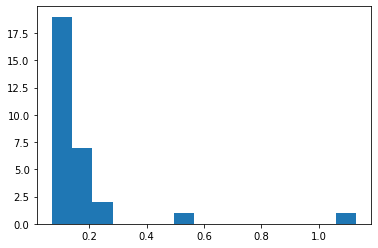

In [180]:
dat = np.array(df.iloc[:,3])
dat = np.concatenate([dat[1410:1420],dat[2040:2060]])
print(dat[:50].flatten())
plt.hist(dat, bins = 15)

In [181]:
# Find a Normal distribution that fits.
tfb = tfp.bijectors
mu = tf.Variable(tf.cast(0, tf.float64))
sigma = tfp.util.TransformedVariable(tf.cast(1., tf.float64), bijector=tfb.Exp())
dist = tfp.distributions.Normal(mu, sigma)

opt_dist(dist, dat,lr=0.1)
print(mu)
print(sigma)

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.18416663214623072>
<TransformedVariable: name=exp, dtype=float64, shape=[], fn="exp", numpy=0.19204636480312667>


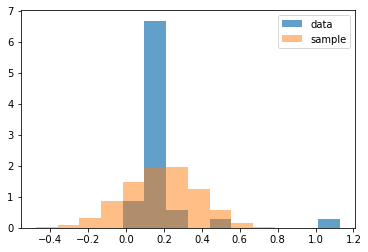

In [182]:
samp = dist.sample(sample_shape=2000)
plot_samp_dat(samp, dat, n_bins = 15)

In [183]:
print(np.mean(dat))
print(np.std(dat))

0.18416666666666665
0.19204636303652187


# **2] Ukraine Private Donations**

In [184]:
url = "https://data.humdata.org/dataset/9bfcd04a-a018-4474-a98d-489ee9fcd7ea/resource/233fb510-120d-4631-8be6-badfaf7f2a6b/download/ukraine-ps-contributions.csv"
filename = "ukraine-ps-contributions.csv"
urllib.request.urlretrieve(url, filename)
df = pd.read_csv(filename)
os.remove(filename)

0      4.218798
1      5.000000
2      6.037426
3      4.698970
4      5.255273
         ...   
308    6.000000
309    5.430393
310    6.050610
311    4.431637
312    4.431637
Name: Est USD value, Length: 313, dtype: float64


(array([20., 34., 56., 77., 46., 57., 13.,  7.,  2.,  1.]),
 array([3.70208572, 4.1477134 , 4.59334108, 5.03896875, 5.48459643,
        5.93022411, 6.37585178, 6.82147946, 7.26710714, 7.71273482,
        8.15836249]),
 <a list of 10 Patch objects>)

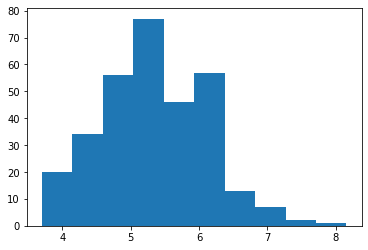

In [185]:
dat = np.log10(df['Est USD value'])
print(dat)
plt.hist(dat)

In [186]:
# Find a Gamma distribution that fits.
tfb = tfp.bijectors
a_shape = tfp.util.TransformedVariable(1., bijector=tfb.Exp())
b_rate = tfp.util.TransformedVariable(1., bijector=tfb.Exp())
dist = tfp.distributions.Gamma(a_shape, b_rate)

opt_dist(dist, dat)
print(a_shape)
print(b_rate)

<TransformedVariable: name=exp, dtype=float32, shape=[], fn="exp", numpy=37.768574>
<TransformedVariable: name=exp, dtype=float32, shape=[], fn="exp", numpy=6.96863>


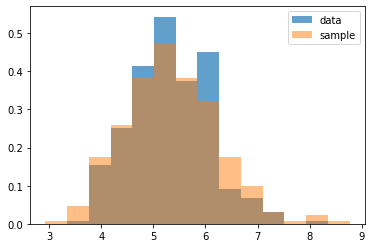

In [187]:
samp = dist.sample(sample_shape=len(dat))
plot_samp_dat(samp, dat)

# **3] Facebook Movement Data**

In [192]:
# Download data
os.mkdir("Meta")
url = "https://data.humdata.org/dataset/c3429f0e-651b-4788-bb2f-4adbf222c90e/resource/3d77ce5c-ab6d-4864-b8a2-c8bafffac4f3/download/movement-range-data-2020-03-01-2020-12-31.zip"
filename = "movement-range-data-2020-03-01-2020-12-31.zip"
urllib.request.urlretrieve(url, filename)
# Unzip
import zipfile
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('./Meta')
df = pd.read_csv('Meta/movement-range-data-2020-03-01--2020-12-31.txt', sep = '\t')
# Clean up
shutil.rmtree("Meta")
os.remove(filename)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [193]:
df['all_day_ratio_single_tile_users']

0          0.18751
1          0.10521
2          0.11397
3          0.10492
4          0.11056
            ...   
5229337    0.09513
5229338    0.09936
5229339    0.08457
5229340    0.08148
5229341    0.08652
Name: all_day_ratio_single_tile_users, Length: 5229342, dtype: float64

(array([6.40000e+01, 6.08000e+02, 4.98400e+03, 2.54210e+04, 7.53200e+04,
        1.51611e+05, 2.38859e+05, 3.27682e+05, 4.15491e+05, 4.68948e+05,
        4.84495e+05, 4.66344e+05, 4.26818e+05, 3.74474e+05, 3.18801e+05,
        2.65306e+05, 2.17427e+05, 1.77173e+05, 1.44292e+05, 1.18259e+05,
        9.81680e+04, 8.13720e+04, 6.65430e+04, 5.34830e+04, 4.28070e+04,
        3.43610e+04, 2.76310e+04, 2.19860e+04, 1.81380e+04, 1.49510e+04,
        1.28480e+04, 1.08780e+04, 9.32100e+03, 7.96000e+03, 6.61500e+03,
        5.45500e+03, 4.36100e+03, 3.22200e+03, 2.24900e+03, 1.54500e+03,
        1.05000e+03, 7.39000e+02, 4.97000e+02, 2.92000e+02, 2.33000e+02,
        1.33000e+02, 8.90000e+01, 2.90000e+01, 6.00000e+00, 3.00000e+00]),
 array([0.02369  , 0.0400556, 0.0564212, 0.0727868, 0.0891524, 0.105518 ,
        0.1218836, 0.1382492, 0.1546148, 0.1709804, 0.187346 , 0.2037116,
        0.2200772, 0.2364428, 0.2528084, 0.269174 , 0.2855396, 0.3019052,
        0.3182708, 0.3346364, 0.351002 , 0.367

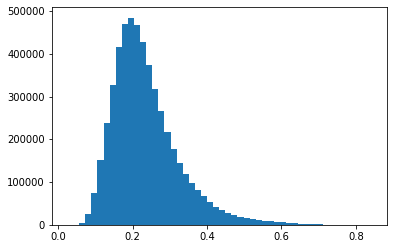

In [194]:
target = 'all_day_ratio_single_tile_users'
dat = df[target]
plt.hist(df[target],bins=50)

In [195]:
# Find a Beta distribution that fits.
tfb = tfp.bijectors
a_shape = tfp.util.TransformedVariable(1., bijector=tfb.Exp())
b_shape = tfp.util.TransformedVariable(1., bijector=tfb.Exp())
dist = tfp.distributions.Beta(a_shape, b_shape)

opt_dist(dist, dat, iters = 20)
print(a_shape)
print(b_shape)

<TransformedVariable: name=exp, dtype=float32, shape=[], fn="exp", numpy=4.1134934>
<TransformedVariable: name=exp, dtype=float32, shape=[], fn="exp", numpy=11.816831>


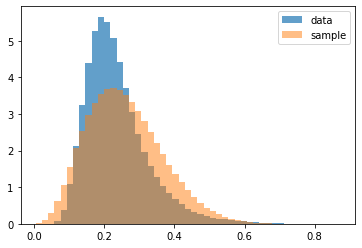

In [196]:
samp = dist.sample(sample_shape=len(dat))
plot_samp_dat(samp, dat, n_bins = 50)

3b] Relative Change in Movement

(array([2.000000e+00, 1.600000e+02, 5.911000e+03, 2.579300e+04,
        6.215500e+04, 9.882700e+04, 1.446110e+05, 2.459660e+05,
        4.210570e+05, 6.510840e+05, 9.388100e+05, 1.163997e+06,
        8.689360e+05, 3.855880e+05, 1.368680e+05, 4.557000e+04,
        1.759400e+04, 7.722000e+03, 3.737000e+03, 2.020000e+03,
        1.108000e+03, 6.480000e+02, 4.220000e+02, 2.510000e+02,
        1.480000e+02, 8.800000e+01, 5.500000e+01, 4.100000e+01,
        2.700000e+01, 2.400000e+01, 1.700000e+01, 1.700000e+01,
        1.100000e+01, 8.000000e+00, 6.000000e+00, 1.500000e+01,
        1.000000e+01, 3.000000e+00, 9.000000e+00, 3.000000e+00,
        3.000000e+00, 4.000000e+00, 4.000000e+00, 1.000000e+00,
        0.000000e+00, 3.000000e+00, 3.000000e+00, 2.000000e+00,
        1.000000e+00, 2.000000e+00]),
 array([-1.       , -0.9171832, -0.8343664, -0.7515496, -0.6687328,
        -0.585916 , -0.5030992, -0.4202824, -0.3374656, -0.2546488,
        -0.171832 , -0.0890152, -0.0061984,  0.0766184,  0

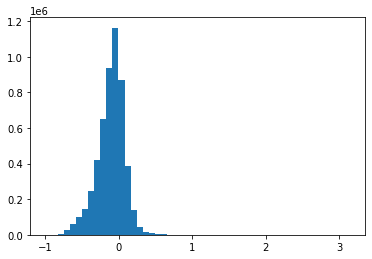

In [197]:
target = 'all_day_bing_tiles_visited_relative_change'
dat = df[target]
plt.hist(df[target],bins=50)

In [198]:
# Fit a Normal distribution
tfb = tfp.bijectors
loc = tf.Variable(tf.cast(0, tf.float64))
scale = tfp.util.TransformedVariable(tf.cast(1, tf.float64), bijector=tfb.Exp())

dist = tfp.distributions.Normal(loc = loc, scale = scale)

opt_dist(dist, dat, iters = 100, lr = 1.)

print(loc)
print(scale)

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.11223759861258352>
<TransformedVariable: name=exp, dtype=float64, shape=[], fn="exp", numpy=0.18219633126366716>


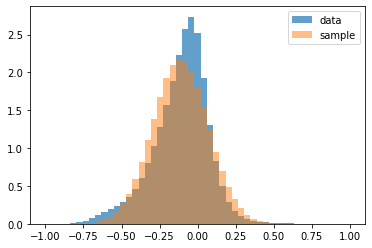

In [199]:
samp = dist.sample(sample_shape=len(dat))
plot_samp_dat(samp, dat, n_bins = 50, xmin = -1, xmax = 1)

In [200]:
# Find a Skewed distribution that fits.
tfb = tfp.bijectors
loc = tf.Variable(tf.cast(-0.05714, tf.float64))
scale = tfp.util.TransformedVariable(tf.cast(0.177, tf.float64), bijector=tfb.Exp())
skewness = tf.Variable(tf.cast(-0.243, tf.float64))
dist = tfp.distributions.SinhArcsinh(loc = loc, scale = scale, skewness = skewness)

opt_dist(dist, dat, iters = 20, lr = 0.01)
print(loc)
print(scale)
print(skewness)

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.05428034091310756>
<TransformedVariable: name=exp, dtype=float64, shape=[], fn="exp", numpy=0.1777263317522156>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.23939390596265142>


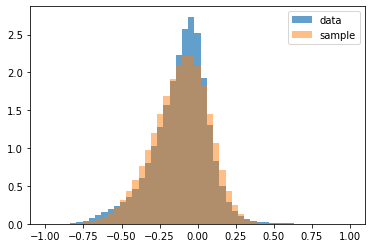

In [202]:
samp = dist.sample(sample_shape=len(dat))
plot_samp_dat(samp, dat, n_bins = 50, xmin = -1, xmax = 1)

In [203]:
tw = tfp.util.TransformedVariable(tf.cast(1., tf.float64), bijector=tfb.Exp())
dist = tfp.distributions.SinhArcsinh(loc = loc, scale = scale, skewness = skewness, tailweight = tw)

opt_dist(dist, dat, iters = 20, lr = 0.01)
print(loc)
print(scale)
print(skewness)
print(tw)

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.05755361014965133>
<TransformedVariable: name=exp, dtype=float64, shape=[], fn="exp", numpy=0.17946229391684265>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.2298297347240176>
<TransformedVariable: name=exp, dtype=float64, shape=[], fn="exp", numpy=1.2108397002295148>


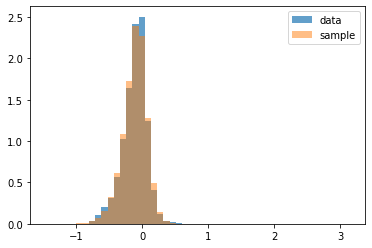

In [205]:
samp = dist.sample(sample_shape=len(dat))
plot_samp_dat(samp, dat, n_bins = 50, xmin = -1, xmax = 1)

# **4] Pass/Fail**

In [207]:
# Summary of Binomial Data
N = 769
x = 493
p = x/N
print(p)

0.6410923276983095


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

(array([276.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 493.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

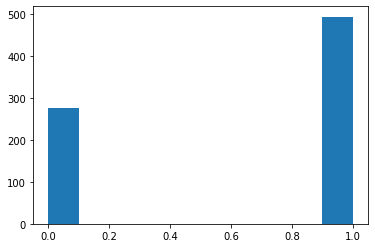

In [208]:
# Long-form of binomial data.
dat = np.concatenate([np.repeat(0,N-x), np.repeat(1,x)])
print(dat)
plt.hist(dat)

In [209]:
p = tfp.util.TransformedVariable(tf.cast(0.5, tf.float64), bijector=tfb.Sigmoid())
dist = tfp.distributions.Bernoulli(probs = p)

opt_dist(dist, dat, iters = 5000)
print(p)

<TransformedVariable: name=sigmoid, dtype=float64, shape=[], fn="sigmoid", numpy=0.641091539996395>


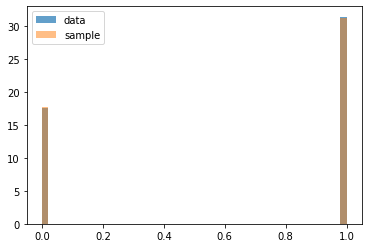

In [210]:
samp = dist.sample(sample_shape=len(dat))
plot_samp_dat(samp, dat, n_bins = 50)

# **5] Voting and Election Data**

(array([81282.,     0.,     0.,     0.,     0., 74223.,     0.,     0.,
            0.,  2891.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

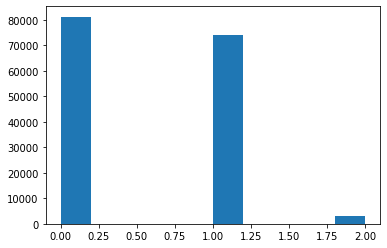

In [211]:
# Election Data
biden_votes = 81282
trump_votes = 74223
indep_votes = 2891
dats = [
        np.repeat(0, biden_votes),
        np.repeat(1, trump_votes),
        np.repeat(2, indep_votes)
]
dat = np.concatenate(dats)
plt.hist(dat)

In [212]:
ps = tfp.util.TransformedVariable(tf.cast(np.array([1/3,1/3,1/3]), tf.float64), bijector=tfb.SoftmaxCentered())
dist = tfp.distributions.Categorical(probs=ps)

opt_dist(dist, dat, iters = 100)
print(ps)

<TransformedVariable: name=softmax_centered, dtype=float64, shape=[3], fn="softmax_centered", numpy=array([0.51286894, 0.46852303, 0.01860803])>


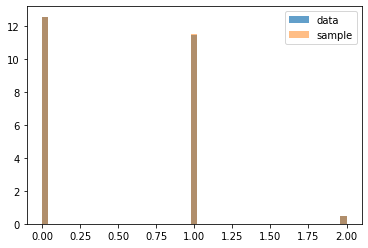

In [213]:
samp = dist.sample(sample_shape=len(dat))
plot_samp_dat(samp, dat, n_bins = 50)


In [214]:
total = biden_votes + trump_votes + indep_votes
print(biden_votes/total)
print(trump_votes/total)
print(indep_votes/total)

0.5131568979014621
0.4685913785701659
0.018251723528371927


# **6] Mystery Data**

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


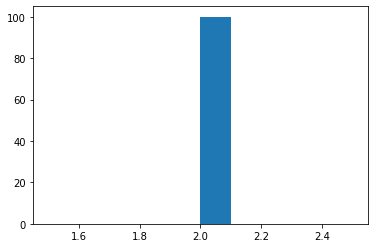

In [215]:
dat = np.repeat(2, 100)

print(dat)
plt.hist(dat);

In [ ]:
dist = tfp.distributions.Deterministic(2)
dist.sample(sample_shape=20)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2.], dtype=float32)>

# **7] Raindrops**

In [216]:
# Download data
df = pd.read_csv("3_14_40.TXT")
df = np.array(df)
isweird = ['_' in str(x) for x in df]
df = [x for i,x in enumerate(df) if not isweird[i]]
df = np.array(df).astype(np.float64)
dat = np.diff(df.flatten())
start_t = 380
end_t = 400
dat = dat[start_t:end_t]

[46. 48. 67. 42. 62. 42. 49. 52. 67. 42. 43. 41. 43. 48. 47. 58. 44. 56.
 50. 56.]


(array([6., 2., 3., 2., 1., 2., 1., 0., 1., 2.]),
 array([41. , 43.6, 46.2, 48.8, 51.4, 54. , 56.6, 59.2, 61.8, 64.4, 67. ]),
 <a list of 10 Patch objects>)

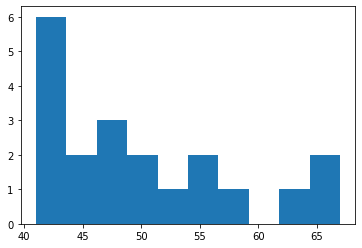

In [217]:
print(dat)
plt.hist(dat)

In [218]:
print(np.mean(dat))
print(np.var(dat))

50.15
65.12750000000001


In [219]:
# Find a Poisson distribution that fits.
tfb = tfp.bijectors
lam = tfp.util.TransformedVariable(0.5, bijector=tfb.Exp())
dist = tfp.distributions.Poisson(rate=lam)

opt_dist(dist, dat, iters = 1000)
print(lam)

<TransformedVariable: name=exp, dtype=float32, shape=[], fn="exp", numpy=50.15>


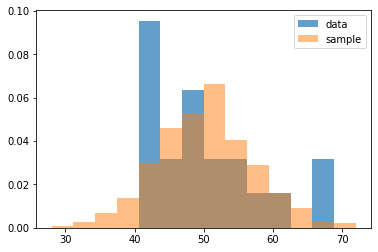

In [220]:
samp = dist.sample(sample_shape=2000)
plot_samp_dat(samp, dat)

# **8] Fatalities in Syria**

In [221]:
url = "https://data.humdata.org/dataset/9d37a9b1-3df5-4bb5-afa8-a22d2ea0e27a/resource/19ec44dc-1e00-49aa-a203-fb0e0a454f3a/download/syria_political_violence_events_and_fatalities_by_month-year.xlsx"
filename = "syria_political_violence_events_and_fatalities_by_month-year.xlsx"
urllib.request.urlretrieve(url, filename)
df = pd.read_excel(filename, sheet_name = 'Data')
os.remove(filename)

2570.9333333333334
120885.79555555555


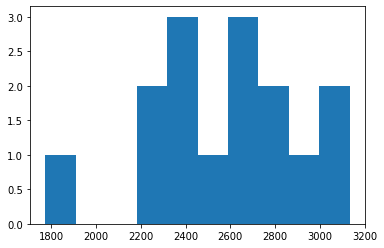

In [222]:
dat = df['Events'][:15]
plt.hist(dat)

print(np.mean(dat))
print(np.var(dat))

In [223]:
# Find a Poisson distribution that fits.
tfb = tfp.bijectors
lam = tfp.util.TransformedVariable(0.5, bijector=tfb.Exp())
dist = tfp.distributions.Poisson(rate=lam)

opt_dist(dist, dat, iters = 1000)
print(lam)

<TransformedVariable: name=exp, dtype=float32, shape=[], fn="exp", numpy=2570.934>


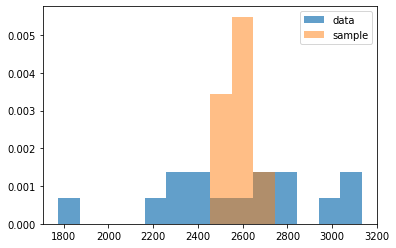

In [224]:
samp = dist.sample(sample_shape=len(dat))
plot_samp_dat(samp, dat)

In [225]:
# Find a Negative Binomial distribution that fits.
tfb = tfp.bijectors
p = tfp.util.TransformedVariable(0.5, bijector=tfb.Sigmoid())
r = tfp.util.TransformedVariable(1., bijector=tfb.Exp())
dist = tfp.distributions.NegativeBinomial(probs=p, total_count = r)

opt_dist(dist, dat, iters = 1000)
print(p)
print(r)

<TransformedVariable: name=sigmoid, dtype=float32, shape=[], fn="sigmoid", numpy=0.98212963>
<TransformedVariable: name=exp, dtype=float32, shape=[], fn="exp", numpy=46.8283>


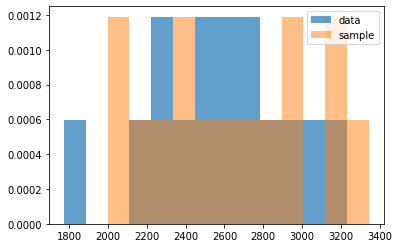

In [226]:
samp = dist.sample(sample_shape=len(dat))
plot_samp_dat(samp, dat)

# **9] Height**

In [227]:
dat = make_height_data()

(array([ 7., 36., 46., 13.,  0.,  0.,  8., 40., 43.,  7.]),
 array([63.41647234, 64.11315526, 64.80983818, 65.5065211 , 66.20320402,
        66.89988694, 67.59656986, 68.29325278, 68.9899357 , 69.68661862,
        70.38330154]),
 <a list of 10 Patch objects>)

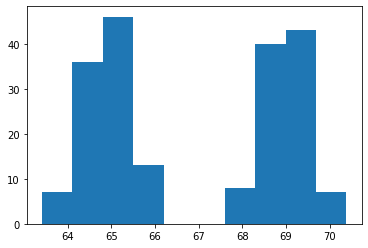

In [228]:
plt.hist(dat)

In [229]:
# Define parameters.
mu_male = tf.Variable(tf.cast(70, tf.float64))
mu_female = tf.Variable(tf.cast(65, tf.float64))
sigma = tfp.util.TransformedVariable(tf.cast(1., tf.float64), bijector=tfb.Exp())
ps = tfp.util.TransformedVariable(tf.cast(np.array([0.5, 0.5]), tf.float64), bijector=tfb.SoftmaxCentered())

# Define distribution
dist_male = tfp.distributions.Normal(loc=mu_male, scale=sigma)
dist_female = tfp.distributions.Normal(loc=mu_female, scale=sigma)
cat = tfp.distributions.Categorical(probs=ps)
dist = tfp.distributions.Mixture(cat, [dist_male, dist_female])

# Optimize!
opt_dist(dist, dat, iters = 1000, lr = 0.1)
print(mu_male)
print(mu_female)
print(ps)

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=68.98916728994689>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=64.89841660054176>
<TransformedVariable: name=softmax_centered, dtype=float64, shape=[2], fn="softmax_centered", numpy=array([0.49, 0.51])>


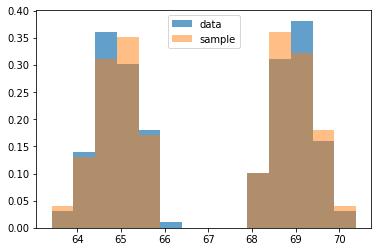

In [230]:
samp = dist.sample(sample_shape=len(dat))
plot_samp_dat(samp, dat)

# **10] Migration**

In [231]:
_,dat,_ = make_migration_data()
print(dat[:50])

tf.Tensor(
[ 0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
  0  0  0  6  2  0  1  0  4  1  0  0  6  0  0  3  0  0  2 24  0  0  0  0
  0  0], shape=(50,), dtype=int64)


(array([831.,  36.,  12.,   8.,   0.,   4.,   2.,   3.,   3.,   1.]),
 array([ 0. ,  3.3,  6.6,  9.9, 13.2, 16.5, 19.8, 23.1, 26.4, 29.7, 33. ]),
 <a list of 10 Patch objects>)

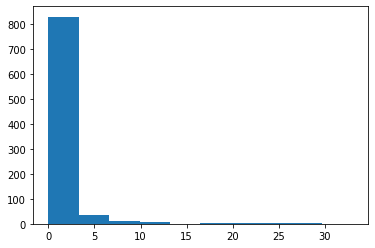

In [232]:
plt.hist(dat)

(array([200.,  26.,   9.,   6.,   0.,   4.,   2.,   3.,   3.,   1.]),
 array([ 1. ,  4.2,  7.4, 10.6, 13.8, 17. , 20.2, 23.4, 26.6, 29.8, 33. ]),
 <a list of 10 Patch objects>)

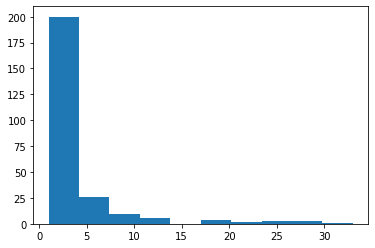

In [234]:
plt.hist(dat[dat!=0])

In [235]:
# Define parameters.
lam_pois = tf.Variable(tf.cast(10., tf.float64))
ps = tfp.util.TransformedVariable(tf.cast(np.array([0.5, 0.5]), tf.float64), bijector=tfb.SoftmaxCentered())

# Define distribution
dist_nonzero = tfp.distributions.Poisson(lam_pois)
dist_zero = tfp.distributions.Deterministic(tf.cast(0, tf.float64))
cat = tfp.distributions.Categorical(probs=ps)
dist = tfp.distributions.Mixture(cat, [dist_zero, dist_nonzero])

# Optimize!
opt_dist(dist, tf.cast(dat, tf.float64), iters = 1000, lr = 0.1)
print(lam_pois)
print(ps)

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.6464335652350726>
<TransformedVariable: name=softmax_centered, dtype=float64, shape=[2], fn="softmax_centered", numpy=array([0.71021914, 0.28978086])>


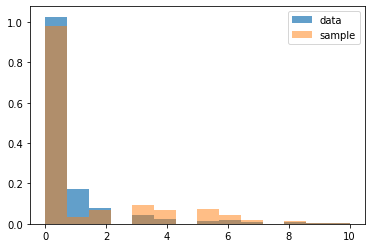

In [236]:
samp = dist.sample(sample_shape=len(dat))
plot_samp_dat(samp, dat, xmin = 0, xmax = 10)

# **11] Abalone Revisited**

[0.225 0.175 0.185 0.205 0.19  0.13  0.515 0.215 0.18  0.17  0.07  0.1
 0.1   0.16  0.09  0.12  0.115 0.115 0.12  0.13  1.13  0.12  0.11  0.11
 0.09  0.14  0.135 0.135 0.11  0.135]


(array([19.,  7.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.]),
 array([0.07      , 0.14066667, 0.21133333, 0.282     , 0.35266667,
        0.42333333, 0.494     , 0.56466667, 0.63533333, 0.706     ,
        0.77666667, 0.84733333, 0.918     , 0.98866667, 1.05933333,
        1.13      ]),
 <a list of 15 Patch objects>)

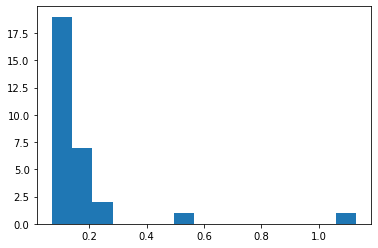

In [237]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
filename = "abalone.data"
urllib.request.urlretrieve(url, filename)
df = pd.read_csv(filename)
os.remove(filename)
dat = np.array(df.iloc[:,3])
dat = np.concatenate([dat[1410:1420],dat[2040:2060]])
print(dat[:50].flatten())
plt.hist(dat, bins = 15)

In [238]:
# Find a Laplace distribution that fits.
tfb = tfp.bijectors
mu = tf.Variable(tf.cast(0, tf.float64))
sigma = tfp.util.TransformedVariable(tf.cast(1., tf.float64), bijector=tfb.Exp())
dist = tfp.distributions.Laplace(mu, sigma)

opt_dist(dist, dat,lr=0.01)
print(mu)
print(sigma)

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.13438777998758908>
<TransformedVariable: name=exp, dtype=float64, shape=[], fn="exp", numpy=0.07550000000000004>


In [240]:
print(np.median(dat))
print(np.mean(dat))
print(np.std(dat))

0.1325
0.18416666666666665
0.19204636303652187
0.07549999999999997


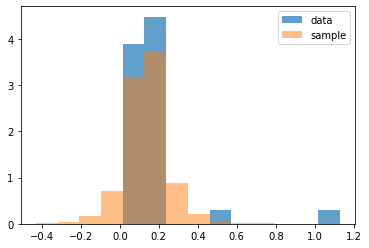

In [241]:
samp = dist.sample(sample_shape=4000)
plot_samp_dat(samp, dat)

# **12] Optimization Details**

Generate Some Data so we Know the Answer:

(array([1., 0., 0., 0., 5., 5., 2., 0., 3., 4.]),
 array([ 9.87927451,  9.89893387,  9.91859323,  9.93825259,  9.95791195,
         9.97757132,  9.99723068, 10.01689004, 10.0365494 , 10.05620876,
        10.07586812]),
 <a list of 10 Patch objects>)

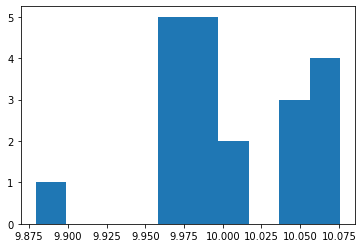

In [253]:
## Generative Story
N = 20
dat = np.random.normal(10., np.exp(-3), size=N)
# "true mu": 10.
# "true sigma": e^(-3) ~= 0.05

plt.hist(dat)

Define our Variables:

In [254]:
# Define parameter variables and distribution
mu = tf.Variable(tf.cast(0., tf.float64))
sigma = tfp.util.TransformedVariable(tf.cast(1, tf.float64), bijector=tfb.Exp())
data_dist = tfpd.Normal(mu, sigma)

Define our **cost function**:

In [255]:
def target_nll():
    log_lik = tf.reduce_sum(data_dist.log_prob(dat))
    return -log_lik

Define and Apply our Optimizer

In [256]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-2)
iters = 4000
costs = tfp.math.minimize(target_nll, iters, optim)

We can see the trajectory of our parameters using trace functions:

In [257]:
def trace_fn(traceable_quantities):
    step, loss, gradients, parameters, has_converged, convergence_criterion_state,\
        optimizer_state, seed = traceable_quantities
    return(loss, tf.concat(parameters,0))

# Reset Variables
mu.assign(tf.cast(0, tf.float64))
sigma.assign(tf.cast(1, tf.float64))

iters = 10000
optim = tf.keras.optimizers.Adam(learning_rate=1e-2)
costs, trace = tfp.math.minimize(target_nll, iters, optim, trace_fn = trace_fn)


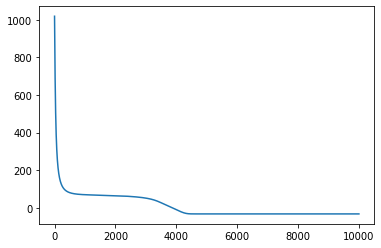

In [258]:
plt.plot(costs)

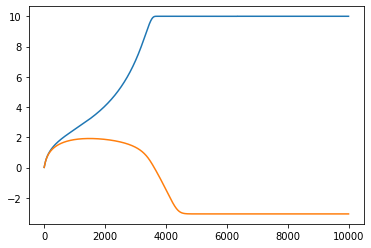

In [259]:
plt.plot(trace)

Text(0, 0.5, 'logsigma')

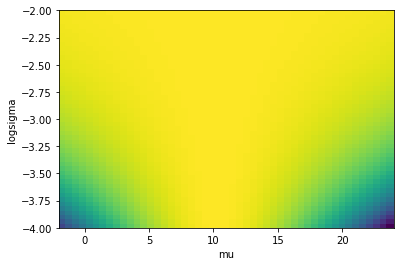

In [260]:
## Look at 3D function!
from mpl_toolkits.mplot3d import Axes3D

grid_res = 50
xgrid = np.linspace(-2,24, num = grid_res)
#xgrid = np.linspace(8,12, num = grid_res)
ygrid = np.linspace(-4,-2, num = grid_res)
xr = [np.min(xgrid), np.max(xgrid)]
yr = [np.min(ygrid), np.max(ygrid)]

costs = np.zeros([grid_res,grid_res])
for i,x in enumerate(xgrid):
    mu.assign(x)
    for j,y in enumerate(ygrid):
        sigma.assign(np.exp(y))
        nll = target_nll()
        costs[i,j] = nll

X, Y = np.meshgrid(xgrid, ygrid)
costs = np.zeros((grid_res,grid_res))

for i in range(grid_res):
   for j in range(grid_res):
       mu.assign(X[i,j])
       sigma.assign(np.exp(Y[i,j]))
       costs[i,j] = target_nll()

# create the figure
fig = plt.figure()
eps = 1e-1
#toplot = -np.log10(costs-np.min(costs)+eps)
toplot = -costs
plt.pcolor(X, Y, toplot)
plt.xlabel('mu')
plt.ylabel('logsigma')

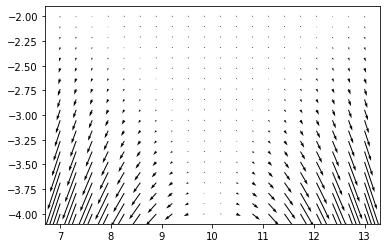

In [270]:
### Now do a vector field plot showing where the gradient points
grid_res = 20
xgrid = np.linspace(7,13, num = grid_res)
#xgrid = np.linspace(8,12, num = grid_res)
ygrid = np.linspace(-4,-2, num = grid_res)

x,y = np.meshgrid(xgrid, ygrid)

v = np.zeros_like(x)
u = np.zeros_like(x)

for i in range(grid_res):
   for j in range(grid_res):
       mu.assign(x[i,j])
       sigma.assign(np.exp(y[i,j]))
       with tf.GradientTape() as gt:
           c = target_nll()
       g = gt.gradient(c, [mu, sigma.trainable_variables])
       v[i,j] = float(g[0])
       u[i,j] = float(g[1][0])

plt.quiver(x,y,v,u)

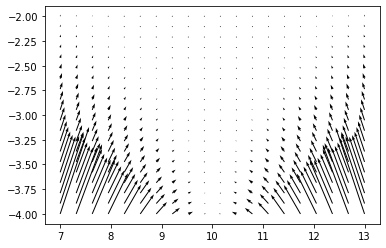

In [271]:
plt.quiver(x,y,-v,-u)

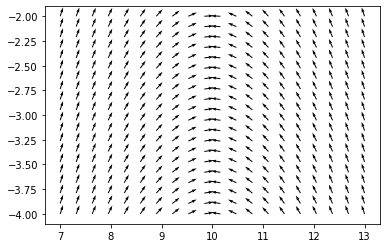

In [273]:
norms = np.sqrt(np.square(u)+np.square(v))
plt.quiver(x,y,-v/norms,-u/norms)

# **13] Linear Model**

In [274]:
X_dat,y_dat,dest = make_migration_data()
y_dat = tf.cast(y_dat, tf.float64)

(array([843.,  31.,  11.,   9.,   3.,   1.,   1.,   0.,   0.,   1.]),
 array([ 0. ,  3.4,  6.8, 10.2, 13.6, 17. , 20.4, 23.8, 27.2, 30.6, 34. ]),
 <a list of 10 Patch objects>)

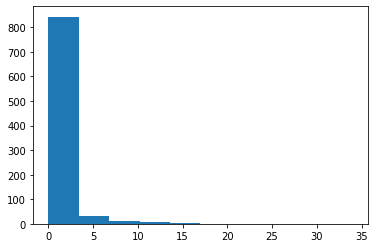

In [275]:
plt.hist(y_dat)

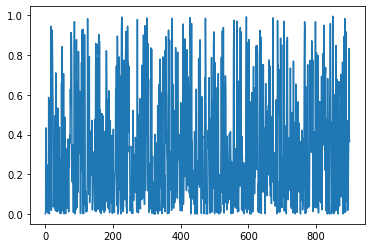

In [276]:
plt.plot(X_dat[:,0])

In [277]:
X_dat.shape

TensorShape([900, 7])

In [278]:
# Get the linear regression solution
P = X_dat.shape[1]
beta_var = tf.Variable(tf.cast(np.random.normal(size=[P]), tf.float64))
beta_int = tf.Variable(tf.cast(0., tf.float64))
sigma = tfp.util.TransformedVariable(tf.cast(1, tf.float64), bijector=tfb.Exp())

print(beta_var)

<tf.Variable 'Variable:0' shape=(7,) dtype=float64, numpy=
array([-0.20997374,  0.30079544, -0.82037552, -0.62266349,  0.30129048,
        0.15491186,  0.87407981])>


In [279]:
preds = tf.linalg.matvec(X_dat, beta_var)+beta_int
print(preds[:20])

tf.Tensor(
[ 0.38145201  0.07183616 -0.11530472 -0.31570317  0.55233507  0.19754695
  0.9402445  -0.11718994  0.36371045  0.29249072  0.38692281 -0.28613782
 -0.22689223  0.33578049 -0.76498975  0.11526876  0.12293301 -0.10002838
 -0.42169172  0.25560424], shape=(20,), dtype=float64)


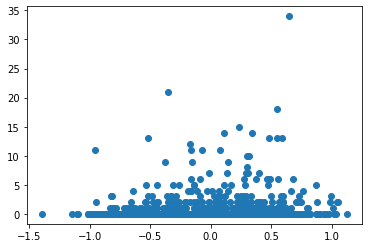

In [280]:
plt.scatter(preds, y_dat)

In [281]:
cost = lambda: -tf.reduce_sum(tfpd.Normal(loc=tf.linalg.matvec(X_dat, beta_var)+beta_int,scale=sigma).log_prob(y_dat))
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
iters=5000
tfp.math.minimize(cost, iters, opt)

<tf.Tensor: shape=(5000,), dtype=float64, numpy=
array([3776.50264925, 3701.93503064, 3630.64239276, ..., 2036.16304631,
       2036.16304631, 2036.16304631])>

<tf.Variable 'Variable:0' shape=(7,) dtype=float64, numpy=
array([-1.35037352,  1.88861015, -0.25326501,  0.23643381,  0.26479467,
        0.12142906,  0.08613417])>


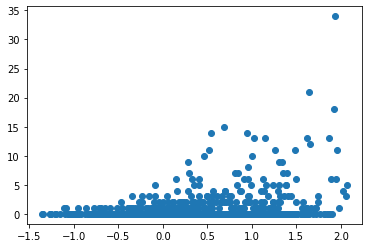

In [282]:
print(beta_var)
preds = tf.linalg.matvec(X_dat, beta_var)
plt.scatter(preds, y_dat)

In [283]:
N = X_dat.shape[0]
X1 = np.concatenate([np.ones([N,1]),X_dat],axis=1)
print("Analytic Soln:")
print(np.linalg.lstsq(X1, y_dat)[0])
print("Our Soln:")
print(beta_int)
print(beta_var)

Analytic Soln:
[ 0.44914951 -1.35037352  1.88861015 -0.25326501  0.23643381  0.26479467
  0.12142906  0.08613417]
Our Soln:
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4491495111217022>
<tf.Variable 'Variable:0' shape=(7,) dtype=float64, numpy=
array([-1.35037352,  1.88861015, -0.25326501,  0.23643381,  0.26479467,
        0.12142906,  0.08613417])>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


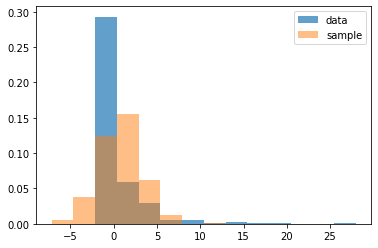

In [ ]:
dist = tfpd.Normal(loc=tf.linalg.matvec(X_dat, beta_var)+beta_int,scale=sigma)
samp = dist.sample()

plot_samp_dat(samp, y_dat)

# **14] Zero-Inflated Poisson Linear Model**

In [ ]:
N,P = X_dat.shape
beta_var = tf.Variable(tf.cast(np.random.normal(size=[P]), tf.float64))
beta_int = tf.Variable(tf.cast(0., tf.float64))
ps = tfp.util.TransformedVariable(tf.cast(np.array([0.5, 0.5]), tf.float64), bijector=tfb.SoftmaxCentered())

print(beta_var)
print(beta_int)
print(ps)

<tf.Variable 'Variable:0' shape=(7,) dtype=float64, numpy=
array([ 0.40935502,  0.77184664, -1.14295204, -0.38341631,  1.84837995,
        0.39207805,  0.74739296])>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.0>
<TransformedVariable: name=softmax_centered, dtype=float64, shape=[2], fn="softmax_centered", numpy=array([0.5, 0.5])>


In [ ]:
preds = tf.linalg.matvec(X_dat, beta_var)
print(preds.shape)
tf.tile(ps[tf.newaxis,:], [N,1]).shape

(900,)


TensorShape([900, 2])

In [ ]:
def cost():
  preds = tf.linalg.matvec(X_dat, beta_var)+beta_int
  dist_nonzero = tfp.distributions.Poisson(log_rate=preds)
  dist_zero = tfp.distributions.Deterministic(loc=tf.zeros_like(preds))
  cat = tfp.distributions.Categorical(probs=tf.tile(ps[tf.newaxis,:], [N,1]))
  dist = tfp.distributions.Mixture(cat, [dist_zero, dist_nonzero])
  return -tf.reduce_sum(dist.log_prob(y_dat))

opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
iters=100
tfp.math.minimize(cost, iters, opt)

<tf.Tensor: shape=(100,), dtype=float64, numpy=
array([1391.4795454 , 1384.86318073, 1378.48747147, 1372.35000352,
       1366.44440949, 1360.7594082 , 1355.27790984, 1349.97667909,
       1344.82724274, 1339.79849395, 1334.86058488, 1329.98873778,
       1325.1655256 , 1320.38113188, 1315.63213994, 1310.91974352,
       1306.24802486, 1301.6225759 , 1297.04949447, 1292.53468991,
       1288.08341777, 1283.69997988, 1279.38754824, 1275.14808916,
       1270.98237561, 1266.89008075, 1262.86994597, 1258.92001153,
       1255.03789118, 1251.22106418, 1247.46715295, 1243.77415405,
       1240.14059523, 1236.56560239, 1233.04887415, 1229.59057589,
       1226.19117676, 1222.85125995, 1219.57133723, 1216.35169541,
       1213.1922938 , 1210.09272199, 1207.05221672, 1204.06972703,
       1201.14401109, 1198.27374469, 1195.45762273, 1192.69443867,
       1189.98313309, 1187.32280881, 1184.7127159 , 1182.15221426,
       1179.64072369, 1177.17767176, 1174.76244862, 1172.39437541,
       1170.07

In [ ]:
print(beta_var)
print(beta_int)
print(ps)

<tf.Variable 'Variable:0' shape=(7,) dtype=float64, numpy=
array([-4.40499707e-01,  1.46656444e+00, -2.55827226e-01, -7.23606278e-03,
        9.66970870e-01, -2.45945671e-01,  4.44495411e-04])>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.3059957102951628>
<TransformedVariable: name=softmax_centered, dtype=float64, shape=[2], fn="softmax_centered", numpy=array([0.6701884, 0.3298116])>


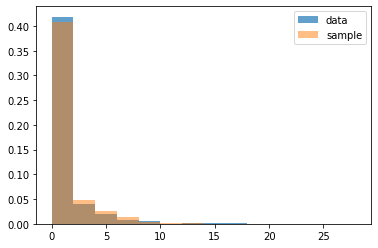

In [ ]:
preds = tf.linalg.matvec(X_dat, beta_var)+beta_int
dist_nonzero = tfp.distributions.Poisson(log_rate=preds)
dist_zero = tfp.distributions.Deterministic(loc=tf.zeros_like(preds))
cat = tfp.distributions.Categorical(probs=tf.tile(ps[tf.newaxis,:], [N,1]))
dist = tfp.distributions.Mixture(cat, [dist_zero, dist_nonzero])

samp = dist.sample()

plot_samp_dat(samp, y_dat)

# **15] Bayesian Inference**

In [ ]:
import arviz as az

In [ ]:
def cost_bayes(beta_var, beta_int, ps):
  preds = tf.linalg.matvec(X_dat, beta_var)+beta_int
  dist_nonzero = tfp.distributions.Poisson(log_rate=preds)
  dist_zero = tfp.distributions.Deterministic(loc=tf.zeros_like(preds))
  cat = tfp.distributions.Categorical(probs=tf.tile(ps[tf.newaxis,:], [N,1]))
  dist = tfp.distributions.Mixture(cat, [dist_zero, dist_nonzero])
  nll = -tf.reduce_sum(dist.log_prob(y_dat))
  
  zero = tf.cast(0, tf.float64)
  ten = tf.cast(1e-2, tf.float64)
  dist_beta_var = tfp.distributions.Normal(zero, ten)
  dist_beta_int = tfp.distributions.Normal(zero, ten)
  nlprior = -tf.reduce_sum(dist_beta_var.log_prob(beta_var)) - \
    tf.reduce_sum(dist_beta_int.log_prob(beta_int)) 
  
  return nll + nlprior

In [ ]:
B = 2000
kernel = tfp.mcmc.RandomWalkMetropolis(cost_bayes, new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=5e-3, name=None))
samples, is_accepted = tfp.mcmc.sample_chain(
  num_burnin_steps=1000,
  num_results=B,
  current_state=[beta_var, beta_int, ps],
  kernel=kernel,
  trace_fn=lambda _, pkr: pkr.is_accepted)
print(np.mean(is_accepted))
print(len(is_accepted))

0.4915
2000


In [ ]:
samples[0] = tf.reshape(samples[0], [1,B,-1])
samples[1] = tf.reshape(samples[1], [1,B,1])
samples[2] = tf.reshape(samples[2], [1,B,-1])

In [ ]:
[x.shape for x in samples]

[TensorShape([1, 10000, 7]),
 TensorShape([1, 10000, 1]),
 TensorShape([1, 10000, 2])]

In [ ]:
parameter_names = ['coefs','int','ps']
trace = az.from_dict(
    posterior={
        k: v for k, v in zip(parameter_names, samples)
    }
)
print([x.shape for x in samples])

[TensorShape([1, 10000, 7]), TensorShape([1, 10000, 1]), TensorShape([1, 10000, 2])]


In [ ]:
print(trace)

Inference data with groups:
	> posterior


In [ ]:
az.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],-0.619,0.415,-1.311,-0.067,0.392,0.430,1.0,14.0,NaN
coefs[1],8.470,2.632,4.005,12.533,2.413,2.550,1.0,10.0,NaN
coefs[2],1.433,1.561,-0.672,4.009,1.428,1.487,1.0,11.0,NaN
coefs[3],2.204,1.610,0.082,4.882,1.485,1.568,1.0,10.0,NaN
coefs[4],5.894,2.298,1.919,9.385,2.122,2.243,1.0,10.0,NaN
coefs[5],1.416,1.245,-0.426,3.445,1.134,1.174,1.0,11.0,NaN
coefs[6],2.071,1.270,0.089,4.085,1.180,1.261,1.0,10.0,NaN
int[0],6.331,3.391,0.784,11.300,3.145,3.346,1.0,10.0,NaN
ps[0],0.736,0.163,0.501,1.000,0.152,0.164,1.0,22.0,NaN
ps[1],0.502,0.073,0.383,0.638,0.046,0.038,3.0,18.0,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb67a2f3950>,
      dtype=object)

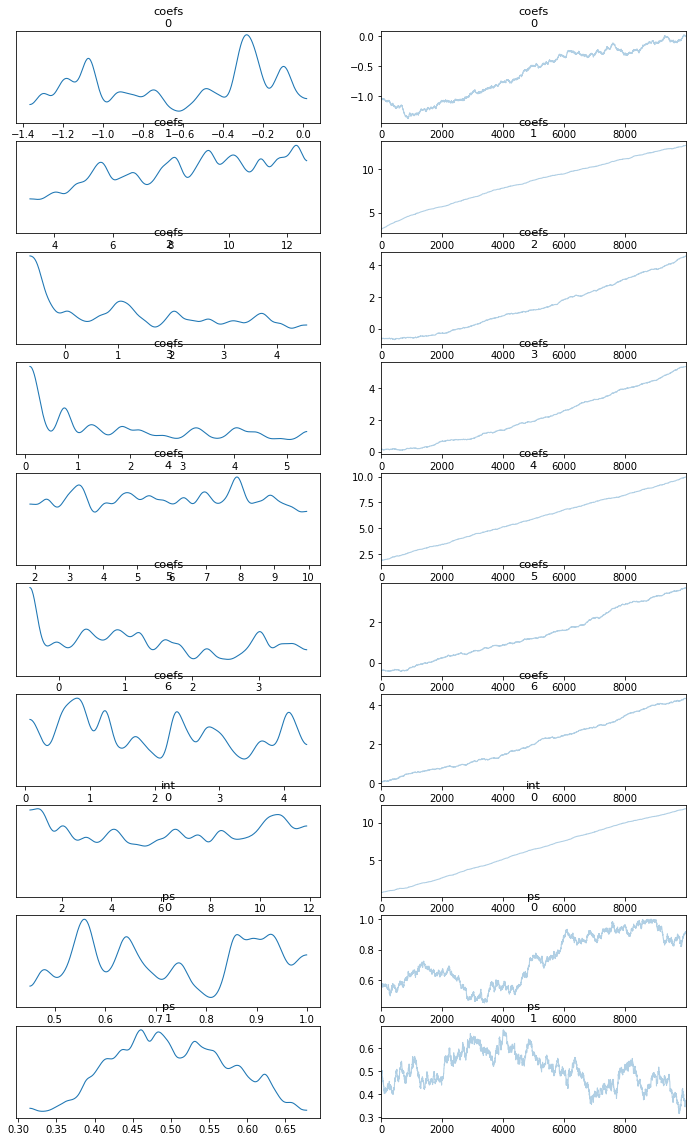

In [ ]:
az.plot_trace(trace, compact = False)

In [ ]:
samples

[<tf.Tensor: shape=(1, 100, 7), dtype=float64, numpy=
 array([[[-0.43284985,  1.60572606, -0.37776605,  0.1546056 ,
           1.02586058, -0.08204619,  0.06327374],
         [-0.43284985,  1.60572606, -0.37776605,  0.1546056 ,
           1.02586058, -0.08204619,  0.06327374],
         [-0.42801926,  1.58620719, -0.37300927,  0.17555204,
           1.03823293, -0.07728049,  0.06295667],
         [-0.42492509,  1.58617663, -0.3570121 ,  0.1560113 ,
           1.04351898, -0.07585597,  0.05751885],
         [-0.42492509,  1.58617663, -0.3570121 ,  0.1560113 ,
           1.04351898, -0.07585597,  0.05751885],
         [-0.42492509,  1.58617663, -0.3570121 ,  0.1560113 ,
           1.04351898, -0.07585597,  0.05751885],
         [-0.43046362,  1.58186735, -0.36162921,  0.17335412,
           1.04515327, -0.07032639,  0.06363881],
         [-0.43046362,  1.58186735, -0.36162921,  0.17335412,
           1.04515327, -0.07032639,  0.06363881],
         [-0.42740853,  1.59839561, -0.35953115,  